In [1]:
import os
import json
import csv
import gym
import fire

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from neurosim.game_interface import GameInterface
from neurosim.critic import Critic
from neurosim.conf import now_str

critic_config = '../config.json'

wdir_e = '../results/20210801-1000it-1eps/500s-evaluation_10'
rew_file = os.path.join(wdir_e, 'ActionsRewards.txt')
results_file = os.path.join(wdir_e, 'ActionsPerEpisode.txt')
motor_file = os.path.join(wdir_e, 'MotorOutputs.txt')
config_file = os.path.join(wdir_e, 'backupcfg_sim.json')

In [2]:
with open(critic_config) as f:
    config = json.load(f)
critic = Critic(config)

In [3]:
class MockAIGame:
    observations = []
    rewards = []
    env = None
    def __init__(self, env):
        self.env = env
    


with open(config_file) as f:
    config = json.load(f)

env = gym.make('CartPole-v1')
game = MockAIGame(env)
gi = GameInterface(game, config)

motor = {}
with open(motor_file) as f:
    for row in csv.reader(f, delimiter='\t'):
        motor[row[0]] = [int(float(i)) for i in row[1:]]


In [62]:
# extract the data

steps = []

with open(rew_file) as f:
    prev_obs = None
    prev_fr = None
    for row in csv.reader(f, delimiter='\t'):
        t, move, critic_val, obs_space_j = row
        obs_space = json.loads(obs_space_j)
        game.observations = [obs_space]
        fr = gi.input_firing_rates()
        frind = (fr > 0).nonzero()[0]
        motor_v = motor[t] if len(steps) > 0 else [0,0]
        is_unk_move = motor_v[0] == motor_v[1]
#         print(type(fr) == np.ndarray)
#         break
        steps.append({
            'move': move,
            'is_unk_move': is_unk_move,
            'critic_run': float(critic_val),
            'critic': critic.calc_reward(np.array(obs_space), np.array(prev_obs), is_unk_move),
            'motor': motor_v,
            'obs': obs_space,
            'fr': list(frind),
            'prev_obs': prev_obs,
            'prev_fr': list(prev_fr) if type(prev_fr) == np.ndarray else None
        })
        prev_obs = obs_space
        prev_fr = frind
        

print('total steps: ', len(steps))
        
results = []
with open(results_file) as f:
    for row in csv.reader(f, delimiter='\t'):
        results.append(int(float(row[1])))
        
print('results:', len(results))
print('steps from results:', sum(results))

total steps:  10041
results: 28
steps from results: 10026


In [63]:
# separate by iteration

steps_seq = []

idx = 0
for r in results:
    steps_seq.append(steps[idx:idx+r])
    idx += r
    
print([len(s) for s in steps_seq])

[481, 254, 500, 500, 500, 500, 272, 500, 341, 500, 251, 299, 356, 183, 111, 500, 500, 455, 498, 433, 196, 322, 239, 276, 277, 171, 195, 416]


In [64]:
for s in steps_seq[:2]:
    print(s[-2])

{'move': '1.0', 'is_unk_move': True, 'critic_run': -1.0, 'critic': -0.7017543859649122, 'motor': [3, 3], 'obs': [1.0908147774095465, 0.06959499994893784, -0.19372380871831854, -1.1532560648896841], 'fr': [17, 31, 40, 61], 'prev_obs': [1.0933639153210244, -0.12745689557389214, -0.17751566546633354, -0.8104071625992497], 'prev_fr': [17, 28, 40, 62]}
{'move': '0.0', 'is_unk_move': False, 'critic_run': -0.24174, 'critic': 1.2209585265709144, 'motor': [5, 4], 'obs': [-1.8801297761164417, -0.4744682985550732, -0.19931287814305954, -0.820616480409647], 'fr': [0, 24, 40, 62], 'prev_obs': [-1.8744877752194355, -0.28210004485031054, -0.17826360151889317, -1.0524638312083179], 'prev_fr': [0, 26, 40, 61]}


In [65]:

critic_vals = []

for steps in steps_seq:
    vals = []
    if len(steps) == 500:
        for j in steps[:-1]:
            left, right = j['motor']
            if left != right:
                vals.append(j['critic'])
        critic_vals.append(vals)
    
print('steps for each 500eps run that are not unk:', [len(cv) for cv in critic_vals])

steps for each 500eps run that are not unk: [434, 452, 475, 466, 436, 467, 442, 462]


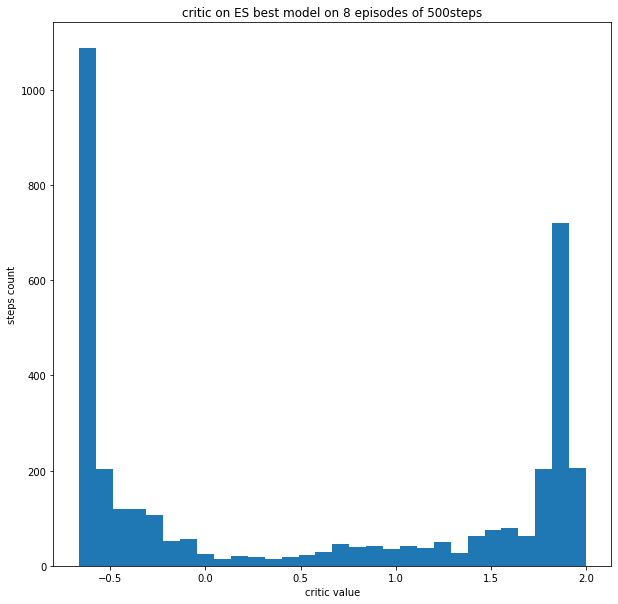

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.hist([v for cv in critic_vals for v in cv], bins=30)
plt.title('critic on ES best model on {} episodes of 500steps'.format(len(critic_vals)))
plt.xlabel('critic value')
plt.ylabel('steps count')
plt.show()

In [67]:
import numpy as np

print('Magnitude of average critic result', round(np.mean([v for cv in critic_vals for v in cv]), 3))
print('Magnitude of average critic result per episode', [round(np.mean(cv), 3) for cv in critic_vals])

print('--')

print('Ratio of reward/punishment', round(
    np.mean([1 if v > 0 else 0 for cv in critic_vals for v in cv]), 3))
print('Ratio of reward/punishment per episode', [round(np.mean([1 if v > 0 else 0 for v in cv]), 3) for cv in critic_vals])

Magnitude of average critic result 0.547
Magnitude of average critic result per episode [0.546, 0.553, 0.542, 0.566, 0.552, 0.556, 0.547, 0.514]
--
Ratio of reward/punishment 0.515
Ratio of reward/punishment per episode [0.518, 0.52, 0.507, 0.511, 0.523, 0.51, 0.527, 0.506]


## Investigate lowest values in terms of firing rates and observation space

In [68]:
steps_of_500 = []

for steps in steps_seq:
    vals = []
    if len(steps) == 500:
        for s in steps:
            if s['critic'] < 0 and s['is_unk_move'] == False:
                steps_of_500.append(s)

print(len(steps_of_500))

1762


len ch_sign 705


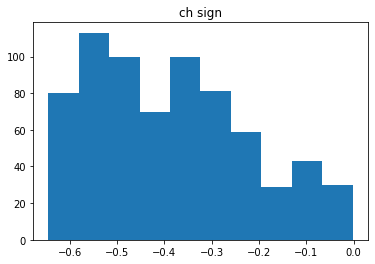

len no change sign 1057


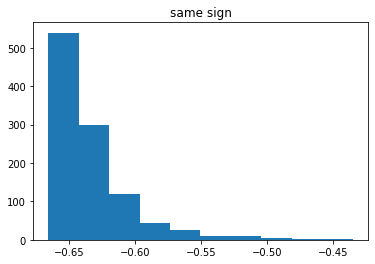

In [82]:
for s in steps_of_500:
    s['obs_angv_ch_sign'] = True if s['obs'][3] * s['prev_obs'][3] < 0 else False

plt.hist([s['critic'] for s in steps_of_500 if s['obs_angv_ch_sign']])
print('len ch_sign', len([s['critic'] for s in steps_of_500 if s['obs_angv_ch_sign']]))
plt.title('ch sign')
plt.show()
plt.hist([s['critic'] for s in steps_of_500 if not s['obs_angv_ch_sign']])
print('len no change sign', len([s['critic'] for s in steps_of_500 if not s['obs_angv_ch_sign']]))
plt.title('same sign')
plt.show()

In [69]:
steps_of_500 = sorted(steps_of_500, key=lambda x:x['critic'])

In [70]:
[(s['critic']) for s in steps_of_500[:5]]

[-0.6660595207403984,
 -0.6644879370500689,
 -0.6643506171342741,
 -0.6640412012759731,
 -0.6639915954634559]

In [83]:
[(s['critic'], s['prev_obs'][2:], s['obs'][2:]) for s in steps_of_500 if s['obs_angv_ch_sign']][:50]

[(-0.6449346298655143,
  [0.0018920799051475763, -0.0006112095513426952],
  [0.0018798557141207223, 0.2926680904835014]),
 (-0.6439026619924432,
  [0.0015122691237404269, 0.0007906675647836869],
  [0.0015280824750361006, -0.2914147365230429]),
 (-0.6389238685345867,
  [-0.001491349507903814, 0.0029698344146297795],
  [-0.0014319528196112183, -0.29018325798857936]),
 (-0.6385488625198519,
  [0.0012789745547587463, 0.002755441348006149],
  [0.0013340833817188692, -0.28952367917126437]),
 (-0.6370554790413532,
  [0.0030757589203063993, -0.001737426753739002],
  [0.0030410103852316194, 0.29191435027844576]),
 (-0.635606984276435,
  [-0.0026455180408014806, -0.0015431372129323107],
  [-0.0026763807850601266, 0.2903039237299515]),
 (-0.6353337403542072,
  [-0.0028330549029811675, -0.0012676438283403257],
  [-0.002858407779547974, 0.29052007490540105]),
 (-0.6352335813245547,
  [-0.0024231449489331962, -0.0020806427208104328],
  [-0.002464757803349405, 0.2898367684106394]),
 (-0.6345109020236

In [75]:
[(s['critic'], s['prev_obs'][2:], s['obs'][2:]) for s in steps_of_500 if s['obs'][3] < 0][-50:]

[(-0.20524413665175012,
  [0.0026436208020268297, 0.1000832109836649],
  [0.004645285021700128, -0.1917644889837017]),
 (-0.20006715548810977,
  [0.00851544793923389, 0.1000834279503478],
  [0.010517116498240844, -0.18990077835634]),
 (-0.19675530323384813,
  [0.007835901668587794, 0.10098959164962618],
  [0.009855693501580318, -0.18921086559285588]),
 (-0.19508635630266505,
  [-0.010275747091400955, 0.10350754256941536],
  [-0.008205596240012648, -0.19239955127536157]),
 (-0.18980776453285442,
  [0.015443964415523408, 0.10057410237769815],
  [0.01745544646307737, -0.1871965616361862]),
 (-0.1896480952886791,
  [0.002916569964516783, 0.10353650538742598],
  [0.004987300072265303, -0.1882248286759453]),
 (-0.18773333339078271,
  [0.003550134661166305, 0.1038611189045322],
  [0.005627357039256949, -0.18769964225613472]),
 (-0.18254168658043024,
  [0.010763970771060685, 0.10353796726692777],
  [0.01283473011639924, -0.18572962228832712]),
 (-0.17763777218541277,
  [0.020354579300115472, 0

In [49]:
prev_obs, curr_obs = ([0,0, 0.010115322829615376, -0.30229472323071627],
  [0,0, 0.00406942836500105, -0.00643888418187788])

In [61]:
critic.calc_reward(np.array(curr_obs), np.array(prev_obs))

2.0

In [54]:
curr_loss = critic._loss(curr_obs)

In [55]:
prev_loss = critic._loss(prev_obs)

In [59]:
curr_loss - prev_loss

-0.1305830231161892